# 图像分类

在此项目中，将对 [Kaggle Dog vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) 中的图片进行分类。该数据集包含猫狗。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。


## 获取数据

下载 [Kaggle Dog Vs Cat](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)。


In [1]:
"""
需要手动下载zip压缩包
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import zipfile


dog_vs_cat_dataset_folder_path = 'train'

zip_path = 'train.zip'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(zip_path):
    print('this not files in there')

if not isdir(dog_vs_cat_dataset_folder_path):
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall()
        zf.close()




## 探索数据

该数据集分成了两个部分：

train 数据集和 test 数据集。

训练过程中主要使用 train 数据集进行训练，然后通过test数据集进行测试。

从kaggle的题目中我们得知文件名中包含有dog 的为包含有狗的照片，包含有cat 的为包含有猫的照片。

运行下一个cell 得到的结果显示：
```
In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;

In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;

```
在测试数据集中图片是全部未标记的。需要我们训练模型之后进行结果输出。


## 获取文件夹下图片

传入floder 目录地址以读取文件，使用ratio 控制拆分数据为测试集和验证机的比率

### 随机化数据





In [3]:
import os
import numpy as np
import math
import tensorflow as tf

def get_all_files_name(floder,ratio=1):
    file_list = os.listdir(floder)
    file_list = list(map(lambda x : os.path.join(floder,x), file_list))

    dog_jpg = list(filter(lambda x : 'dog' in x  , file_list))
    cat_jpg = list(filter(lambda x : 'cat' in x  , file_list))

    print('In the %s floder , All Jpg file is %s ;' % (floder, len(file_list)))
    print('In the %s floder , Dog jpg file is %s ;' % (floder, len(dog_jpg)))
    print('In the %s floder , Cat Jpg file is %s ;' % (floder, len(cat_jpg)))
    
    
    image_list = np.hstack((cat_jpg, dog_jpg))
    label_list = np.hstack(([0] * len(cat_jpg), [1]*len(dog_jpg)))
    
    # 将数据打乱为随机数据
    temp = np.array([image_list, label_list])
    temp = temp.transpose()
    np.random.shuffle(temp) 
    
    all_image_list = temp[:, 0]
    all_label_list = temp[:, 1]
    
    #计算数据划分的训练集和验证集的分割点
    n_sample = len(all_label_list)
    n_val = math.ceil(n_sample*ratio) # number of validation samples
    n_train = n_sample - n_val # number of trainning samples
    
    #依据分割点划分数据
    tra_images = all_image_list[0:n_train]
    tra_labels = all_label_list[0:n_train]
    tra_labels = [int(float(i)) for i in tra_labels]
    val_images = all_image_list[n_train:-1]
    val_labels = all_label_list[n_train:-1]
    val_labels = [int(float(i)) for i in val_labels]
    
    return tra_images,tra_labels,val_images,val_labels
    
    
get_all_files_name('test')

tra_images,tra_labels,val_images,val_labels = get_all_files_name('train')

In the test floder , All Jpg file is 12500 ;
In the test floder , Dog jpg file is 0 ;
In the test floder , Cat Jpg file is 0 ;
In the train floder , All Jpg file is 25000 ;
In the train floder , Dog jpg file is 12500 ;
In the train floder , Cat Jpg file is 12500 ;


## 实现预处理函数

### 标准化

对输入的图片进行标准化，然后返回 图片batch


In [2]:
def get_batch(image, label, image_W, image_H, batch_size, capacity):
    '''
    Args:
        image: list type
        label: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''
    # 如果想看到正常的图片，请注释掉（标准化）和 130行（image_batch = tf.cast(image_batch, tf.float32)）
    # 训练时，不要注释掉！
    
    image = tf.cast(image, tf.string)
    label = tf.cast(label, tf.int32)

    # make an input queue
    input_queue = tf.train.slice_input_producer([image, label])
    
    label = input_queue[1]
    image_contents = tf.read_file( input_queue[0])
    
    
    ## 图片标准化 注释这一行和下面cast可以看到正常图片
    image = tf.image.decode_jpeg(image_contents, channels=3)
    
    # 裁剪图片
    image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)    
    image = tf.image.per_image_standardization(image)
    image_batch, label_batch = tf.train.batch([image, label],
                                                batch_size= batch_size,
                                                num_threads= 64, 
                                                capacity = capacity)
    label_batch = tf.reshape(label_batch, [batch_size])
    
    ## 图片向量转化
    image_batch = tf.cast(image_batch, tf.float32)
    
    return image_batch, label_batch

# 测试图片标准化函数

In [4]:
% matplotlib inline
import matplotlib.pyplot as plt

BATCH_SIZE = 2
CAPACITY = 256
IMG_W = 208
IMG_H = 208

train_dir = 'train/'
ratio = 0.2
tra_images, tra_labels, val_images, val_labels = get_all_files_name(train_dir, ratio)
tra_image_batch, tra_label_batch = get_batch(tra_images, tra_labels, IMG_W, IMG_H, BATCH_SIZE, CAPACITY)

In the train/ floder , All Jpg file is 25000 ;
In the train/ floder , Dog jpg file is 12500 ;
In the train/ floder , Cat Jpg file is 12500 ;


label: 1


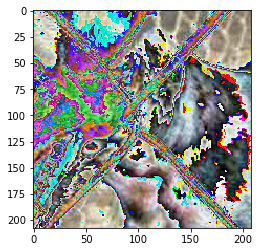

label: 0


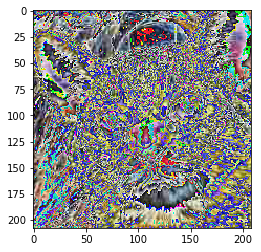

In [5]:
with tf.Session() as sess:
   i = 0
   coord = tf.train.Coordinator()
   threads = tf.train.start_queue_runners(coord=coord)
   
   try:
       while not coord.should_stop() and i<1:
           
           img, label = sess.run([tra_image_batch, tra_label_batch])
           
           # just test one batch
           for j in np.arange(BATCH_SIZE):
               print('label: %d' %label[j])
               plt.imshow(img[j,:,:,:])
               plt.show()
           i+=1
           
   except tf.errors.OutOfRangeError:
       print('done!')
   finally:
       coord.request_stop()
   coord.join(threads)

## 构建网络

对于该神经网络，你需要将每层都构建为一个函数。你看到的大部分代码都位于函数外面。要更全面地测试你的代码，我们需要你将每层放入一个函数中。这样使我们能够提供更好的反馈，并使用我们的统一测试检测简单的错误，然后再提交项目。

>**注意**：如果你觉得每周很难抽出足够的时间学习这门课程，我们为此项目提供了一个小捷径。对于接下来的几个问题，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 程序包中的类来构建每个层级，但是“卷积和最大池化层级”部分的层级除外。TF Layers 和 Keras 及 TFLearn 层级类似，因此很容易学会。

>但是，如果你想充分利用这门课程，请尝试自己解决所有问题，不使用 TF Layers 程序包中的任何类。你依然可以使用其他程序包中的类，这些类和你在 TF Layers 中的类名称是一样的！例如，你可以使用 TF Neural Network 版本的 `conv2d` 类 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)，而不是 TF Layers 版本的 `conv2d` 类 [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)。

我们开始吧！



In [5]:
def create_var(var_name, shape, dtype,init):
    return tf.get_variable(var_name, shape=shape, dtype=dtype,initializer=init)

def create_wb( weight_shape, biase_shape,stddev):
    weights = create_var('weights',
                         shape=weight_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal_initializer(stddev=stddev,dtype=tf.float32))
    biases = create_var('biases',
                         shape=biase_shape, 
                         dtype=tf.float32, 
                         init=tf.truncated_normal(0.1),
                       reuse=tf.AUTO_REUSE)
    return weights, biases


def get_pre_activation(images,weight_shape, biases_shape,stddev,strides):
    weights , biases = create_wb(weight_shape, biases_shape,stddev=stddev )
    conv = tf.nn.conv2d(images, weights, strides = strides,pandding='SAME')
    pre_activation = tf.nn.bias_add(conv,biases)
    return pre_activation
    


In [6]:
def inference(images, batch_size, n_classes):
    '''Build the model
    Args:
        images: image batch, 4D tensor, tf.float32, [batch_size, width, height, channels]
    Returns:
        output tensor with the computed logits, float, [batch_size, n_classes]
    '''
    #conv1, shape = [kernel size, kernel size, channels, kernel numbers]
    
    with tf.variable_scope('conv1') as scope:
        weights = tf.get_variable('weights', 
                                  shape = [3,3,3, 16],
                                  dtype = tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[16],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(images, weights, strides=[1,1,1,1], padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name= scope.name)
    
    #pool1 and norm1   
    with tf.variable_scope('pooling1_lrn') as scope:
        pool1 = tf.nn.max_pool(conv1, ksize=[1,3,3,1],strides=[1,2,2,1],
                               padding='SAME', name='pooling1')
        norm1 = tf.nn.lrn(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm1')
    
    #conv2
    with tf.variable_scope('conv2') as scope:
        weights = tf.get_variable('weights',
                                  shape=[3,3,16,16],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.1,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[16], 
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        conv = tf.nn.conv2d(norm1, weights, strides=[1,1,1,1],padding='SAME')
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name='conv2')
    
    
    #pool2 and norm2
    with tf.variable_scope('pooling2_lrn') as scope:
        norm2 = tf.nn.lrn(conv2, depth_radius=4, bias=1.0, alpha=0.001/9.0,
                          beta=0.75,name='norm2')
        pool2 = tf.nn.max_pool(norm2, ksize=[1,3,3,1], strides=[1,1,1,1],
                               padding='SAME',name='pooling2')
    
    
    #local3
    with tf.variable_scope('local3') as scope:
        reshape = tf.reshape(pool2, shape=[batch_size, -1])
        dim = reshape.get_shape()[1].value
        weights = tf.get_variable('weights',
                                  shape=[dim,128],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        local3 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)    
    
    #local4
    with tf.variable_scope('local4') as scope:
        weights = tf.get_variable('weights',
                                  shape=[128,128],
                                  dtype=tf.float32, 
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases',
                                 shape=[128],
                                 dtype=tf.float32,
                                 initializer=tf.constant_initializer(0.1))
        local4 = tf.nn.relu(tf.matmul(local3, weights) + biases, name='local4')
     
        
    # softmax
    with tf.variable_scope('softmax_linear') as scope:
        weights = tf.get_variable('softmax_linear',
                                  shape=[128, n_classes],
                                  dtype=tf.float32,
                                  initializer=tf.truncated_normal_initializer(stddev=0.005,dtype=tf.float32))
        biases = tf.get_variable('biases', 
                                 shape=[n_classes],
                                 dtype=tf.float32, 
                                 initializer=tf.constant_initializer(0.1))
        softmax_linear = tf.add(tf.matmul(local4, weights), biases, name='softmax_linear')
    
    return softmax_linear

In [7]:
def losses(logits, labels):
    '''Compute loss from logits and labels
    Args:
        logits: logits tensor, float, [batch_size, n_classes]
        labels: label tensor, tf.int32, [batch_size]
        
    Returns:
        loss tensor of float type
    '''
    with tf.variable_scope('loss') as scope:
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits\
                        (logits=logits, labels=labels, name='xentropy_per_example')
        loss = tf.reduce_mean(cross_entropy, name='loss')
        tf.summary.scalar(scope.name+'/loss', loss)
    return loss

In [8]:
def evaluation(logits, labels):
  """Evaluate the quality of the logits at predicting the label.
  Args:
    logits: Logits tensor, float - [batch_size, NUM_CLASSES].
    labels: Labels tensor, int32 - [batch_size], with values in the
      range [0, NUM_CLASSES).
  Returns:
    A scalar int32 tensor with the number of examples (out of batch_size)
    that were predicted correctly.
  """
  with tf.variable_scope('accuracy') as scope:
      correct = tf.nn.in_top_k(logits, labels, 1)
      correct = tf.cast(correct, tf.float16)
      accuracy = tf.reduce_mean(correct)
      tf.summary.scalar(scope.name+'/accuracy', accuracy)
  return accuracy

In [9]:

def trainning(loss, learning_rate):
    '''Training ops, the Op returned by this function is what must be passed to 
        'sess.run()' call to cause the model to train.
        
    Args:
        loss: loss tensor, from losses()
        
    Returns:
        train_op: The op for trainning
    '''
    with tf.name_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_op = optimizer.minimize(loss, global_step= global_step)
    return train_op



In [10]:
import os
import numpy as np
import tensorflow as tf


#%%

N_CLASSES = 2
IMG_W = 208  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
RATIO = 0.2 # take 20% of dataset as validation data 
BATCH_SIZE = 64
CAPACITY = 2000
MAX_STEP = 6000 # with current parameters, it is suggested to use MAX_STEP>10k
learning_rate = 0.0001 # with current parameters, it is suggested to use learning rate<0.0001


#%%
def run_training():
    
    # you need to change the directories to yours.
    train_dir = 'train/'
    logs_train_dir = 'logs/train/'
    logs_val_dir = 'logs/val/'
    
    train, train_label, val, val_label = get_all_files_name(train_dir, RATIO)
    train_batch, train_label_batch = get_batch(train,
                                                  train_label,
                                                  IMG_W,
                                                  IMG_H,
                                                  BATCH_SIZE, 
                                                  CAPACITY)
    train_logits = inference(train_batch, BATCH_SIZE, N_CLASSES)
    train_loss = losses(train_logits, train_label_batch)        
    train_op = trainning(train_loss, learning_rate)
    train__acc = evaluation(train_logits, train_label_batch)
       
    summary_op = tf.summary.merge_all()
    sess = tf.Session()
    train_writer = tf.summary.FileWriter(logs_train_dir, sess.graph)
    saver = tf.train.Saver()
    
    sess.run(tf.global_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        for step in np.arange(MAX_STEP):
            if coord.should_stop():
                    break
            _, tra_loss, tra_acc = sess.run([train_op, train_loss, train__acc])
               
            if step % 50 == 0:
                print('Step %d, train loss = %.2f, train accuracy = %.2f%%' %(step, tra_loss, tra_acc*100.0))
                summary_str = sess.run(summary_op)
                train_writer.add_summary(summary_str, step)
            
            if step % 2000 == 0 or (step + 1) == MAX_STEP:
                checkpoint_path = os.path.join(logs_train_dir, 'model.ckpt')
                saver.save(sess, checkpoint_path, global_step=step)
                
    except tf.errors.OutOfRangeError:
        print('Done training -- epoch limit reached')
    finally:
        coord.request_stop()
        
    coord.join(threads)
    sess.close()

In [ ]:
run_training()

In [24]:
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

def get_test_image():
    '''Randomly pick one image from training data
    Return: ndarray
    '''
    test_dir = 'test'
    file_list = os.listdir(test_dir)
    file_list = list(map(lambda x: os.path.join(test_dir, x), file_list))
    images = []
    for img_dir in file_list:
        image = Image.open(img_dir)
        #         plt.imshow(image)
        image = image.resize([208, 208])
        image = np.array(image)
        images.append((img_dir, image))
    return images

def evaluate_one_image(image_array):
    '''Test one image against the saved models and parameters
    '''

    # you need to change the directories to yours.

    with tf.Graph().as_default():
        BATCH_SIZE = 1
        N_CLASSES = 2

        image = tf.cast(image_array, tf.float32)
        image = tf.image.per_image_standardization(image)
        image = tf.reshape(image, [1, 208, 208, 3])
        logit = inference(image, BATCH_SIZE, N_CLASSES)

        logit = tf.nn.softmax(logit)

        x = tf.placeholder(tf.float32, shape=[208, 208, 3])

        # you need to change the directories to yours.
        logs_train_dir = 'logs/train/'

        saver = tf.train.Saver()

        with tf.Session() as sess:

            print("Reading checkpoints...")
            ckpt = tf.train.get_checkpoint_state(logs_train_dir)
            if ckpt and ckpt.model_checkpoint_path:
                global_step = ckpt.model_checkpoint_path.split('/')[-1].split('-')[-1]
                saver.restore(sess, ckpt.model_checkpoint_path)
                print('Loading success, global_step is %s' % global_step)
            else:
                print('No checkpoint file found')

            prediction = sess.run(logit, feed_dict={x: image_array})
            max_index = np.argmax(prediction)

            if max_index == 0:
                print('This is a cat with possibility %.6f' % prediction[:, 0])
                pred = (0,prediction[:, 0][0])
            else:
                print('This is a dog with possibility %.6f' % prediction[:, 1])
                pred = (1,prediction[:, 1][0])
            return pred


In [13]:
all_images = get_test_image()

In [28]:
with open('result.txt', 'a+') as f:
    for img_dir, images in all_images:
        pred = evaluate_one_image(images)
        f.write(str(img_dir + ',' + '%d,%.6f' % (pred) + '\n'))
        
        

Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.914207
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986703
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.914540
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibi

Loading success, global_step is 5999
This is a cat with possibility 0.999959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.976384
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999860
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.981691
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.826228
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999967
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.970876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.600656
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999457
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955431
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994395
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.852996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.989135
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.857543
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.755317
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997736
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998104
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991624
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.927832
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.912817
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999769
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999118
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.973204
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.910672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.959858
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999807
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999060
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.656148
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998871
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.882753
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993921
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.696803
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999968
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999496
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999967
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999516
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.858459
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.654723
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.660685
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.935496
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999943
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999651
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.907721
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.988996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999386
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995378
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.994395
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.875763
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998171
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.976089
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968158
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.894870
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999872
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999674
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999943
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.952932
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.956636
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998561
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.711431
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985813
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.983642
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.621239
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.529934
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992135
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997388
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.854365
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.924203
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999584
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999898
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999752
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999926
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990750
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994846
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999908
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.847706
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999668
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.988247
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.875803
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.945237
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999796
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.581625
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994458
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.633717
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.965066
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.972203
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999435
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.990677
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999686
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982445
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.726778
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999037
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.810597
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.636166
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999771
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.879149
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997689
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.658150
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999762
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.575852
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.714652
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968903
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993851
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999674
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998159
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995055
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.963240
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.992901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991838
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.888408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.856130
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.727315
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999618
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999927
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.979410
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.989794
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999755
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999572
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.952820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996136
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997031
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.718537
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.654199
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.899390
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999665
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999978
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.947347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.648484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999690
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999102
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999828
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999970
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999694
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992678
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.978357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975717
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.972275
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999322
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.598708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999538
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976238
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999869
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985724
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.975492
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.676391
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999525
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.891646
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999733
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.943244
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.930027
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.768808
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.957229
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999933
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991698
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.928484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999795
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996667
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.920664
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976913
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998601
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.517468
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.931922
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.910197
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999830
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998706
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999422
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.777249
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999510
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997286
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.949120
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999727
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999722
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998902
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988250
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.964756
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998276
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.984978
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990452
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.845893
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998378
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.933215
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987474
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999942
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999833
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995721
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.955700
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999805
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999892
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999615
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999376
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979449
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.541586
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999991
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.757316
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969117
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999590
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998869
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999132
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964860
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999880
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998567
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.819474
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.885250
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998951
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.575465
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999813
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969599
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998660
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998912
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998324
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.719182
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.964078
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.967193
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.590655
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998464
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.938611
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.862654
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999372
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988343
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.822038
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997226
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994338
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996470
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998146
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991298
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999472
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999816
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992290
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.737288
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.899742
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.958596
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.885976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.995592
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987738
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.968670
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.685558
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989682
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.975102
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996779
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.541894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.538003
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.804798
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.979745
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998613
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.967243
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.671205
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997778
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986005
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999313
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986179
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.807720
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.972200
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991896
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.518888
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.920484
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998963
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999875
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999891
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999847
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.631105
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.837359
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.861314
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.952442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.901457
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991903
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977273
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995300
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989874
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999049
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997223
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999916
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999984
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.723513
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.676818
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969550
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997838
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.777702
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999967
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999583
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999991
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.971206
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.686881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999793
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999031
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.979679
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999509
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.533453
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993601
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993401
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999064
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.757897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980179
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.932120
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999891
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.948326
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999945
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998796
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999774
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999983
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.844667
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998788
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993898
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996397
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999863
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.796341
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999550
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.990643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.952684
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999892
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.763641
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.996275
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.566928
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999618
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999972
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.635291
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997792
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999220
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995661
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999084
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999831
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.726059
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999623
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.651712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999952
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995260
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.992549
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999796
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999806
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999958
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.943813
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996788
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999818
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.924779
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.806187
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.738269
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.706593
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999493
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999974
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994062
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999957
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999688
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.974666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999566
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990232
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.977027
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991734
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999823
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999938
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991806
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999379
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.805158
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.925886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.858968
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999618
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993421
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998470
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.991008
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.910542
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995245
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.546977
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997471
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996018
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999933
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.556845
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.910628
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.800482
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975506
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.705712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.851750
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.980088
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.917899
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998825
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.639788
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978869
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.981303
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.981928
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.995141
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999839
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.816008
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.906798
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.916353
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994805
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.692828
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993757
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.965359
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.976857
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.511285
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.965680
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998202
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.962519
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996529
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998442
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999885
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997281
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998189
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.686100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.595809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999577
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.502615
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.928517
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.826519
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997752
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999499
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.937932
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.829006
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998681
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997229
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.668527
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.718305
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996223
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999698
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998517
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.707626
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999840
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.792394
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.984232
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998632
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964712
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.819446
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994153
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.977890
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.748851
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997532
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.787377
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998576
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999977
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.729167
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999987
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.991902
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998033
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.510569
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.551975
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982027
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999207
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999980
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969489
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999009
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999954
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991695
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.922164
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992383
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988564
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.980920
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985201
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999672
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.886685
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999971
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999782
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998705
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991115
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998618
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.585012
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995797
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978139
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987140
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibi

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994443
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.888659
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999902
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999912
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999215
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999749
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991707
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999183
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999601
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999761
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999975
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999687
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.685862
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998347
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999108
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989703
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969475
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.984346
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.985709
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999896
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.987083
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999790
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.713804
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998742
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.940430
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.986761
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999949
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996807
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980743
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.890896
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999821
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.965415
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999854
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999191
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.967245
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999643
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.879277
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999964
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999957
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999302
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999628
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.888048
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.994351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986047
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998941
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.930561
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999282
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999912
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.597518
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999665
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.941675
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994829
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.969005
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.971389
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.912131
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.802257
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.916380
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998376
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999819
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999979
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.987500
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996074
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999001
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999827
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.925048
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.890908
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999984
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.769468
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.962385
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999917
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996707
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999967
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.557260
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999819
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.899687
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996385
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969836
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999801
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.987134
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.647773
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992803
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993222
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.906583
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.959408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997798
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.769649
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992563
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996193
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.706669
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999416
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.994357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.924486
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999828
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.924320
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999252
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999913
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995977
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.880080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.649401
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995966
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.777282
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.989969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999042
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999050
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999989
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.655688
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991118
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.996730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999729
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.946319
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.707943
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.877730
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.895533
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.603358
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.647294
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998905
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994520
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992848
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.851221
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999984
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.646777
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.895386
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994502
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996461
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.897284
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.839908
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.722327
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.922976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.799191
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.992617
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999619
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999987
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.935245
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999450
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998161
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998918
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993868
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.530960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999862
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.874535
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999196
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.716858
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999948
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999593
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999627
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996893
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997231
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.944988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992925
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999916
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994218
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.983480
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.973188
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999983
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996884
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998095
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999975
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.835017
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.560196
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999909
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995492
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998748
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980678
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998270
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.901564
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.990962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998467
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.801666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.812648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984698
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.991168
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.982899
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984756
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999883
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.767387
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999957
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998069
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997534
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999750
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.959195
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998715
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.662418
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.998258
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.778858
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.972061
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.673189
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993002
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998778
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.986701
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999498
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999873
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999710
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.905636
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999928
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999882
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.998528
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988485
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983180
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.692021
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994856
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.642938
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.860345
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998427
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971352
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995048
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.604506
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997162
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.916911
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.971211
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993639
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.653481
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999814
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.904975
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999875
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999424
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.870039
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.522117
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.561121
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.758039
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999968
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996767
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999139
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997884
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.971745
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969615
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.988063
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.953666
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.616423
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999148
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.953449
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.733540
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996809
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999938
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999916
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999646
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.993732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997671
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.978321
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999945
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999938
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986589
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998181
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.983901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.890812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999629
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.533345
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.950078
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.567294
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999937
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999693
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999421
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.948907
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.715936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999798
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.898768
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.666383
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998333
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999991
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999918
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999950
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996464
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999914
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.989866
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999607
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.972886
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.630389
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999983
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998427
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999772
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.803861
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999568
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999561
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999339
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.955758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999941
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.925098
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.935393
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.995478
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999905
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997956
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.949064
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.742332
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993482
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.574179
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999562
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.879022
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998184
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.910040
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.659982
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999741
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999972
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.956677
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.572507
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.917016
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.994512
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999765
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.992397
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999301
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.759370
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999816
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.813727
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998289
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991420
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997971
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994446
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.713784
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990432
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.688255
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.687702
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998555
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.869087
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995889
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984212
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999236
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998745
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999676
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.933079
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.998793
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999880
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.774700
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993099
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.627351
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992964
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999267
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999945
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999964
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999644
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998512
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999473
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.962045
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.576053
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.925755
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.550882
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999876
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977154
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999936
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.833224
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995048
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.997109
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.990975
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.621881
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999782
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999776
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.612087
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.572090
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.794136
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997554
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996805
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999841
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.964202
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999691
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999569
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999912
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.856958
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996010
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.973189
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994680
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999554
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.985894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999926
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999991
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.823200
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.991961
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.992833
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.837033
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.991270
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.967814
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.868357
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.723136
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.613378
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.996820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998968
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999865
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999845
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.579111
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.975716
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999894
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999981
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.633974
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997645
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.982812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997136
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.579648
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998473
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.980610
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.948344
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999835
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999732
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997826
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.938071
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999751
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.648644
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999985
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999386
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999041
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999996
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.667144
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999424
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.962262
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.997949
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997521
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999820
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993186
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999727
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999949
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.709784
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999990
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.979565
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994495
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999897
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999995
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.521100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999580
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.828458
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.969927
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.788346
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.638132
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999959
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.972939
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.949965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999853
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.638812
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.984901
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.977827
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.758566
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.990147
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.986464
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998314
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996973
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999708
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.970685
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.970965
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.992879
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.682267
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999986
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999863
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.994318
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.983449
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977172
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999004
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999513
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.891084
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997480
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.765516
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.805570
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999763
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998511
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.997707
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997620
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.996408
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999998
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995577
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999557
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.988025
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999933
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998036
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999947
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.909877
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999080
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.935976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999962
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999940
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999960
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.995689
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.993535
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.984994
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.907591
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999976
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999923
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.887224
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.998934
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.982705
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.990227
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999999
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999875
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999969
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.993100
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.929165
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997958
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999983
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999944
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.843935
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.550953
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999842
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999227
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999615
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.790355
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999988
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.999993
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.977600
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.981020
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.834503
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999469
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.512488
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.848758
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999638
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.997656
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999931
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999963
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a dog with possibility 0.977071
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.943647
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.554844
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 1.000000
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.995210
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo

Loading success, global_step is 5999
This is a cat with possibility 0.999922
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.986955
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.644192
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999958
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a dog with possibility 0.999997
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/model.ckpt-5999
Loading success, global_step is 5999
This is a cat with possibility 0.999992
Reading checkpoints...
INFO:tensorflow:Restoring parameters from logs/train/mo